In [13]:
## for data
import pandas as pd  #1.1.5
import numpy as np  #1.21.0

## for plotting
import matplotlib.pyplot as plt  #3.3.2
import seaborn as sns  #0.11.1
import folium  #0.14.0
from folium import plugins
import plotly.express as px  #5.1.0

## for simple routing
import osmnx as ox  #1.2.2
import networkx as nx  #3.0

## for advanced routing 
from ortools.constraint_solver import pywrapcp  #9.6
from ortools.constraint_solver import routing_enums_pb2


In [14]:
city = "Sao Paulo"
dtf = pd.read_csv('directory.csv')
dtf = dtf[dtf["City"]==city][["City", "Street Address", "Latitude", "Longitude"]].reset_index(drop=True)
dtf = dtf.reset_index().rename( columns={"index":"id", "Latitude":"y", "Longitude":"x"})

print("tot:", len(dtf))
dtf.head(3)


tot: 48


,id,City,Street Address,y,x
0,0,Sao Paulo,"Rua Maestro Cardim, 769",-23.57,-46.64
1,1,Sao Paulo,"Av. Washington Luis, s/n, Sagua Central, Vila ...",-23.63,-46.66
2,2,Sao Paulo,"Av. Paulista, 2.064, Piso Augusta Lojas A-1,A-...",-23.56,-46.66


In [15]:
# pinpoint your starting location
i = 0
dtf["base"] = dtf["id"].apply(lambda x: 1 if x==i else 0)
start = dtf[dtf["base"]==1][["y","x"]].values[0]

print("start =", start)
dtf.head(3)

start = [-23.57 -46.64]


,id,City,Street Address,y,x,base
0,0,Sao Paulo,"Rua Maestro Cardim, 769",-23.57,-46.64,1
1,1,Sao Paulo,"Av. Washington Luis, s/n, Sagua Central, Vila ...",-23.63,-46.66,0
2,2,Sao Paulo,"Av. Paulista, 2.064, Piso Augusta Lojas A-1,A-...",-23.56,-46.66,0


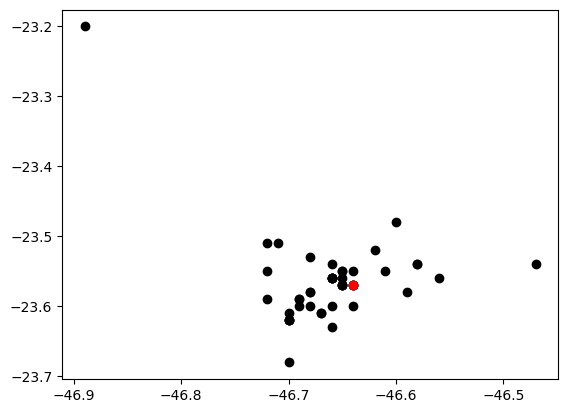

In [16]:
plt.scatter(y=dtf["y"], x=dtf["x"], color="black")
plt.scatter(y=start[0], x=start[1], color="red")
plt.show()

In [17]:
# setup
data = dtf.copy()
color = "base"  #color based on this column
lst_colors = ["black","red"]
popup = "id" #popup based on this column
  
# base map
map_ = folium.Map(location=start, tiles="cartodbpositron", zoom_start=11)

# add colors
lst_elements = sorted(list(data[color].unique()))
data["color"] = data[color].apply(lambda x: 
                  lst_colors[lst_elements.index(x)])

# add popup
data.apply(lambda row: 
    folium.CircleMarker(
            location=[row["y"],row["x"]], popup=row[popup],
            color=row["color"], fill=True, radius=5).add_to(map_), 
    axis=1)

# add full-screen button
plugins.Fullscreen(position="topright", title="Expand", 
      title_cancel="Exit", force_separate_button=True).add_to(map_)

# show
map_

In [18]:
# add lines
for i in range(len(dtf)):
    points = [start, dtf[["y","x"]].iloc[i].tolist()]
    folium.PolyLine(points, tooltip="Coast", color="red", 
                    weight=0.5, opacity=0.5).add_to(map_)

map_

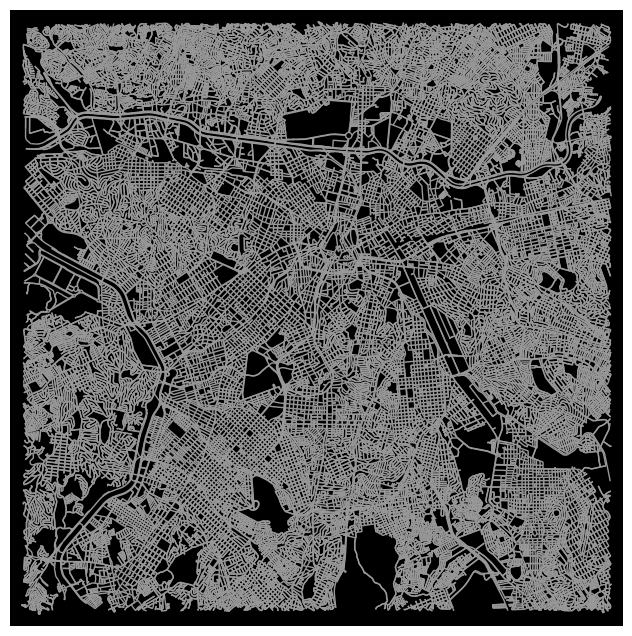

In [19]:
# cria grafo de rede
G = ox.graph_from_point(start, dist= 10000 , 
        network_type= "drive" )   #'drive', 'bike', 'walk'
G = ox.add_edge_speeds(G) 
G = ox.add_edge_travel_times(G) 

# plot
fig, ax = ox.plot_graph(G, bgcolor= "black" , node_size= 0 , 
        node_color= "white" , figsize=( 16 , 8 ))

In [20]:
# geo-dataframe (nodes)
print("nodes:", len(G.nodes()))
ox.graph_to_gdfs(G, nodes=True, edges=False).reset_index().head(3)

nodes: 48389


,osmid,y,x,street_count,highway,ref,geometry
0,573641,-23.562991,-46.703965,3,NaN,NaN,POINT (-46.70397 -23.56299)
1,573643,-23.567465,-46.702229,3,NaN,NaN,POINT (-46.70223 -23.56746)
2,573644,-23.572962,-46.699235,3,NaN,NaN,POINT (-46.69923 -23.57296)


In [21]:
# geo-dataframe (links)
print("links:", len(G.edges()))
ox.graph_to_gdfs(G, nodes=False, edges=True).reset_index().head(3)

links: 110314


,u,v,key,osmid,oneway,lanes,name,highway,reversed,length,...,travel_time,maxspeed,geometry,ref,bridge,junction,width,tunnel,access,est_width
0,573641,4345300990,0,26661283,True,2,Avenida Professor Frederico Herman Júnior,tertiary,False,33.384,...,2.8,NaN,"LINESTRING (-46.70397 -23.56299, -46.70373 -23...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,573641,465879071,0,493634438,True,3,Avenida Doutora Ruth Cardoso,trunk,False,25.403,...,1.5,60,"LINESTRING (-46.70397 -23.56299, -46.70408 -23...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,573643,292424978,0,"[692286399, 493634438, 936811959]",True,"[4, 3]",Avenida Doutora Ruth Cardoso,trunk,False,274.205,...,16.5,60,"LINESTRING (-46.70223 -23.56746, -46.70228 -23...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
end = dtf[dtf["id"]==30][["y","x"]].values[0]
print("locations: from", start, "--> to", end)

locations: from [-23.57 -46.64] --> to [-23.57 -46.65]
